In [101]:
!pip install pandas-datareader
!pip install ta --upgrade
!pip install Prophet
!pip install plotly
!pip install notebook
!pip install ipywidgets

import yfinance as yf

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ta #for Bollinger Bands 
from tabulate import tabulate #for SMA and EMA
from pandas_datareader import data as wb #for Prophet
from prophet import Prophet #for Prophet
import plotly.graph_objects as go #for Prophet
from prophet.plot import plot_plotly, plot_components_plotly #for Prophet

import warnings
warnings.filterwarnings("ignore")


In [102]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [103]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] >= '2019-01-01']
df = df[df['Date/Time'] <= '2021-12-31']

# to check date range
print(df['Date/Time'].min())
print(df['Date/Time'].max())

# set date/time as index
df.set_index('Date/Time', inplace = True)

# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


2019-01-01 00:00:00
2021-12-01 00:00:00


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14256 entries, 2019-01-01 to 2021-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       14256 non-null  object 
 1   Longitude                          14256 non-null  float64
 2   Latitude                           14256 non-null  float64
 3   Region.Name                        14256 non-null  object 
 4   Construction                       14256 non-null  float64
 5   Transportation and warehousing     14256 non-null  float64
 6   Health care and social assistance  14256 non-null  float64
 7   Agriculture                        14256 non-null  float64
 8   Wholesale trade Retail trade       14256 non-null  float64
 9   Population                         14256 non-null  float64
 10  GeoUID                             14256 non-null  object 
 11  Station Name                       14

1. Alberta

In [105]:
# filter for alberta
df1 = df[df['provincename'] == 'Alberta']

In [106]:
# 
df1 = df1.reset_index()
df1[['ds','y']]= df1[['Date/Time','Agriculture']]

#checking changes
df1

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Alberta,-119.75,56.31,Clear Hills (MD),8.350616,12.844433,7.448174,284.434781,7.023227,...,7.3,-30.8,0.0,0.0,18.7,0.0,25.0,70.0,2019-01-01,284.434781
1,2019-02-01,Alberta,-119.75,56.31,Clear Hills (MD),8.839726,12.836617,7.534196,283.719717,7.090874,...,0.7,-40.1,0.0,0.0,19.4,0.0,1.0,42.0,2019-02-01,283.719717
2,2019-03-01,Alberta,-119.75,56.31,Clear Hills (MD),8.677927,13.312018,7.608822,281.216625,6.898219,...,13.7,-33.5,0.0,0.0,0.5,0.0,25.0,63.0,2019-03-01,281.216625
3,2019-04-01,Alberta,-119.75,56.31,Clear Hills (MD),8.769749,13.811211,6.926230,313.635772,7.183179,...,15.7,-7.3,0.0,0.0,11.1,0.0,26.0,64.0,2019-04-01,313.635772
4,2019-05-01,Alberta,-119.75,56.31,Clear Hills (MD),8.928472,13.132707,7.143395,313.200160,7.217651,...,29.5,-4.5,0.0,0.0,10.0,0.0,29.0,60.0,2019-05-01,313.200160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,2021-08-01,Alberta,-110.07,53.31,Vermilion River County (MD),39.083724,27.901770,21.121487,806.698713,47.837988,...,34.0,5.0,28.0,0.0,28.0,0.0,0.0,0.0,2021-08-01,806.698713
2156,2021-09-01,Alberta,-110.07,53.31,Vermilion River County (MD),39.253931,27.049705,23.426492,837.686350,48.887557,...,26.0,-1.0,14.0,0.0,14.0,0.0,0.0,0.0,2021-09-01,837.686350
2157,2021-10-01,Alberta,-110.07,53.31,Vermilion River County (MD),39.647674,28.381184,23.111354,865.808961,49.750888,...,20.5,-9.0,17.2,0.0,17.2,0.0,0.0,0.0,2021-10-01,865.808961
2158,2021-11-01,Alberta,-110.07,53.31,Vermilion River County (MD),40.756362,28.721467,23.082981,807.547012,51.522516,...,11.0,-20.0,2.0,15.4,21.4,5.0,0.0,0.0,2021-11-01,807.547012


In [107]:
#to bring in the model the Prophet
model1= df1
model1.head()

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Alberta,-119.75,56.31,Clear Hills (MD),8.350616,12.844433,7.448174,284.434781,7.023227,...,7.3,-30.8,0.0,0.0,18.7,0.0,25.0,70.0,2019-01-01,284.434781
1,2019-02-01,Alberta,-119.75,56.31,Clear Hills (MD),8.839726,12.836617,7.534196,283.719717,7.090874,...,0.7,-40.1,0.0,0.0,19.4,0.0,1.0,42.0,2019-02-01,283.719717
2,2019-03-01,Alberta,-119.75,56.31,Clear Hills (MD),8.677927,13.312018,7.608822,281.216625,6.898219,...,13.7,-33.5,0.0,0.0,0.5,0.0,25.0,63.0,2019-03-01,281.216625
3,2019-04-01,Alberta,-119.75,56.31,Clear Hills (MD),8.769749,13.811211,6.926230,313.635772,7.183179,...,15.7,-7.3,0.0,0.0,11.1,0.0,26.0,64.0,2019-04-01,313.635772
4,2019-05-01,Alberta,-119.75,56.31,Clear Hills (MD),8.928472,13.132707,7.143395,313.200160,7.217651,...,29.5,-4.5,0.0,0.0,10.0,0.0,29.0,60.0,2019-05-01,313.200160


In [108]:
#to drop the unwanted columns in new dataframe
prophet_1 = model1[['ds', 'y']]
prophet_1

,ds,y
0,2019-01-01,284.434781
1,2019-02-01,283.719717
2,2019-03-01,281.216625
3,2019-04-01,313.635772
4,2019-05-01,313.200160
...,...,...
2155,2021-08-01,806.698713
2156,2021-09-01,837.686350
2157,2021-10-01,865.808961
2158,2021-11-01,807.547012


In [109]:
#to fit the model and the dataframe
m1 = Prophet()
m1.fit(prophet_1)

21:11:21 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
#predict the future for next 365 periods (1 year). For the 2022 year
future1 = m1.make_future_dataframe(periods=13, freq='M')
future1.tail()

,ds
44,2022-08-31
45,2022-09-30
46,2022-10-31
47,2022-11-30
48,2022-12-31


In [111]:
#calculate predict method to assign each row in future a predicted value which it names yhat
predictions1= m1.predict(future1)
predictions1[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
44,2022-08-31,621.861709,-558.238289,1678.315676
45,2022-09-30,636.312813,-382.460496,1651.056600
46,2022-10-31,629.525188,-437.255619,1655.818157
47,2022-11-30,637.668970,-390.838685,1773.764967
48,2022-12-31,616.442159,-476.160434,1672.820281


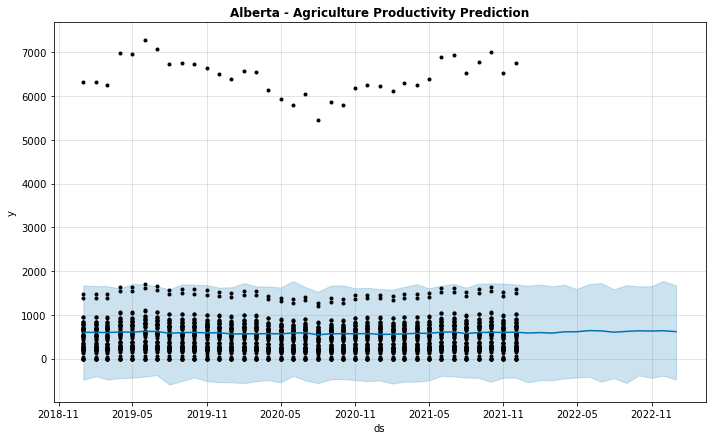

In [112]:
#plot graphs for predictions X axis as time and Y axis as productivity
fig1 = m1.plot(predictions1)
plt.title('Alberta - Agriculture Productivity Prediction', fontweight='bold')
plt.show()

In [113]:
plot_plotly(m1, predictions1)

2.British Columbia

In [114]:
# filter for alberta
df2 = df[df['provincename'] == 'British Columbia']

In [115]:
# 
df2 = df2.reset_index()
df2[['ds','y']]= df2[['Date/Time','Agriculture']]

#checking changes
df2

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.430964,1.747341,0.641414,4.214261,0.957696,...,3.0,-22.0,6.0,10.0,16.0,0.0,0.0,0.0,2019-01-01,4.214261
1,2019-02-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.080559,1.617106,0.635207,4.402273,0.941184,...,7.0,-25.0,0.0,25.6,25.6,0.0,0.0,0.0,2019-02-01,4.402273
2,2019-03-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.408342,1.696240,0.671340,4.771062,0.976793,...,13.0,-15.5,139.2,39.0,178.2,0.0,0.0,0.0,2019-03-01,4.771062
3,2019-04-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.378628,1.830797,0.670617,4.737702,0.937929,...,19.0,-5.0,106.4,18.0,124.4,0.0,0.0,0.0,2019-04-01,4.737702
4,2019-05-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.449445,1.880360,0.661190,5.147343,0.971862,...,25.0,-1.0,24.0,0.0,24.0,0.0,0.0,0.0,2019-05-01,5.147343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5107,2021-08-01,British Columbia,-114.88,49.75,Sparwood (DM),19.180116,5.417121,11.336471,148.025290,21.559750,...,34.3,0.8,0.0,0.0,86.7,0.0,7.0,88.0,2021-08-01,148.025290
5108,2021-09-01,British Columbia,-114.88,49.75,Sparwood (DM),18.135110,5.458880,11.138717,142.329807,20.872035,...,26.1,-4.0,0.0,0.0,16.9,0.0,32.0,82.0,2021-09-01,142.329807
5109,2021-10-01,British Columbia,-114.88,49.75,Sparwood (DM),18.050003,5.415339,11.711730,152.451408,21.578099,...,21.7,-9.3,0.0,0.0,69.8,0.0,18.0,52.0,2021-10-01,152.451408
5110,2021-11-01,British Columbia,-114.88,49.75,Sparwood (DM),17.378067,5.649588,11.778476,146.398891,21.624269,...,10.2,-11.8,0.0,0.0,124.4,1.0,16.0,64.0,2021-11-01,146.398891


In [116]:
#to bring in the model the Prophet
model2= df2
model2.head()

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.430964,1.747341,0.641414,4.214261,0.957696,...,3.0,-22.0,6.0,10.0,16.0,0.0,0.0,0.0,2019-01-01,4.214261
1,2019-02-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.080559,1.617106,0.635207,4.402273,0.941184,...,7.0,-25.0,0.0,25.6,25.6,0.0,0.0,0.0,2019-02-01,4.402273
2,2019-03-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.408342,1.696240,0.671340,4.771062,0.976793,...,13.0,-15.5,139.2,39.0,178.2,0.0,0.0,0.0,2019-03-01,4.771062
3,2019-04-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.378628,1.830797,0.670617,4.737702,0.937929,...,19.0,-5.0,106.4,18.0,124.4,0.0,0.0,0.0,2019-04-01,4.737702
4,2019-05-01,British Columbia,-136.37,59.45,Stikine Region (RDA),2.449445,1.880360,0.661190,5.147343,0.971862,...,25.0,-1.0,24.0,0.0,24.0,0.0,0.0,0.0,2019-05-01,5.147343


In [117]:
#to drop the unwanted columns in new dataframe
prophet_2 = model2[['ds', 'y']]
prophet_2

,ds,y
0,2019-01-01,4.214261
1,2019-02-01,4.402273
2,2019-03-01,4.771062
3,2019-04-01,4.737702
4,2019-05-01,5.147343
...,...,...
5107,2021-08-01,148.025290
5108,2021-09-01,142.329807
5109,2021-10-01,152.451408
5110,2021-11-01,146.398891


In [118]:
#to fit the model and the dataframe
m2 = Prophet()
m2.fit(prophet_2)

21:11:22 - cmdstanpy - INFO - Chain [1] start processing
21:11:22 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
#predict the future for next 365 periods (1 year). For the 2022 year
future2 = m2.make_future_dataframe(periods=13, freq='M')
future2.tail()

,ds
44,2022-08-31
45,2022-09-30
46,2022-10-31
47,2022-11-30
48,2022-12-31


In [120]:
#calculate predict method to assign each row in future a predicted value which it names yhat
predictions2= m2.predict(future2)
predictions2[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
44,2022-08-31,82.779090,-132.039229,307.904148
45,2022-09-30,85.981848,-132.970521,277.631954
46,2022-10-31,92.981344,-110.774920,331.345433
47,2022-11-30,87.070751,-147.904517,305.428579
48,2022-12-31,82.321865,-124.447122,316.628417


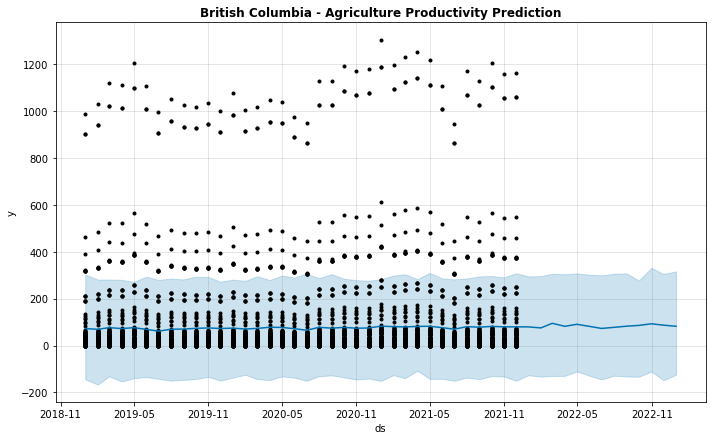

In [121]:
#plot graphs for predictions X axis as time and Y axis as productivity
fig2 = m2.plot(predictions2)
plt.title('British Columbia - Agriculture Productivity Prediction', fontweight='bold')
plt.show()

In [122]:
plot_plotly(m2, predictions2)

3.Quebec

In [123]:
# filter for Quebec
df3 = df[df['provincename'] == 'Quebec']

In [124]:
# 
df3 = df3.reset_index()
df3[['ds','y']]= df3[['Date/Time','Agriculture']]

#checking changes
df3

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),170.887045,59.117469,163.522685,398.439310,215.802959,...,1.600000,-42.100000,0.0,76.8,76.8,52.0,0.0,0.0,2019-01-01,398.439310
1,2019-02-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),164.298249,59.031706,163.332826,394.147753,213.836388,...,1.100000,-34.700000,17.2,108.2,125.4,85.0,0.0,0.0,2019-02-01,394.147753
2,2019-03-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),163.043871,58.719277,163.031895,442.283900,214.498567,...,6.000000,-29.900000,12.4,36.2,48.6,59.0,0.0,0.0,2019-03-01,442.283900
3,2019-04-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),167.093974,59.307759,163.823704,414.599356,232.373476,...,14.800000,-18.300000,96.4,41.8,138.2,10.0,0.0,0.0,2019-04-01,414.599356
4,2019-05-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),166.345036,60.154638,163.328562,379.357885,215.277790,...,27.355852,-2.140798,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-01,379.357885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3091,2021-08-01,Quebec,-64.20,48.85,Gaspé (V),30.772071,16.215789,90.314734,55.610096,76.223806,...,28.000000,4.700000,106.0,0.0,106.0,0.0,0.0,0.0,2021-08-01,55.610096
3092,2021-09-01,Quebec,-64.20,48.85,Gaspé (V),31.420475,16.837193,91.028975,62.246548,75.355814,...,25.000000,1.000000,298.0,0.0,298.0,0.0,0.0,0.0,2021-09-01,62.246548
3093,2021-10-01,Quebec,-64.20,48.85,Gaspé (V),33.041145,17.035005,89.079232,58.163925,74.322030,...,20.000000,-4.000000,63.0,0.0,63.0,0.0,0.0,0.0,2021-10-01,58.163925
3094,2021-11-01,Quebec,-64.20,48.85,Gaspé (V),30.740870,16.624149,89.733151,55.293406,75.447385,...,14.000000,-7.000000,132.0,5.0,137.0,0.0,0.0,0.0,2021-11-01,55.293406


In [125]:
#to bring in the model the Prophet
model3= df3
model3.head()

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),170.887045,59.117469,163.522685,398.439310,215.802959,...,1.600000,-42.100000,0.0,76.8,76.8,52.0,0.0,0.0,2019-01-01,398.439310
1,2019-02-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),164.298249,59.031706,163.332826,394.147753,213.836388,...,1.100000,-34.700000,17.2,108.2,125.4,85.0,0.0,0.0,2019-02-01,394.147753
2,2019-03-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),163.043871,58.719277,163.031895,442.283900,214.498567,...,6.000000,-29.900000,12.4,36.2,48.6,59.0,0.0,0.0,2019-03-01,442.283900
3,2019-04-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),167.093974,59.307759,163.823704,414.599356,232.373476,...,14.800000,-18.300000,96.4,41.8,138.2,10.0,0.0,0.0,2019-04-01,414.599356
4,2019-05-01,Quebec,-78.73,48.42,Rouyn-Noranda (V),166.345036,60.154638,163.328562,379.357885,215.277790,...,27.355852,-2.140798,0.0,0.0,0.0,0.0,0.0,0.0,2019-05-01,379.357885


In [126]:
#to drop the unwanted columns in new dataframe
prophet_3 = model3[['ds', 'y']]
prophet_3

,ds,y
0,2019-01-01,398.439310
1,2019-02-01,394.147753
2,2019-03-01,442.283900
3,2019-04-01,414.599356
4,2019-05-01,379.357885
...,...,...
3091,2021-08-01,55.610096
3092,2021-09-01,62.246548
3093,2021-10-01,58.163925
3094,2021-11-01,55.293406


In [127]:
#to fit the model and the dataframe
m3 = Prophet()
m3.fit(prophet_3)

21:11:23 - cmdstanpy - INFO - Chain [1] start processing
21:11:23 - cmdstanpy - INFO - Chain [1] done processing


In [128]:
#predict the future for next 365 periods (1 year). For the 2022 year
future3 = m3.make_future_dataframe(periods=13, freq='M')
future3.tail()

,ds
44,2022-08-31
45,2022-09-30
46,2022-10-31
47,2022-11-30
48,2022-12-31


In [129]:
#calculate predict method to assign each row in future a predicted value which it names yhat
predictions3= m3.predict(future3)
predictions3[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
44,2022-08-31,40.527013,-42.981347,130.776484
45,2022-09-30,30.023589,-63.524214,121.307937
46,2022-10-31,43.926496,-42.979237,145.400683
47,2022-11-30,40.926831,-45.403948,134.750153
48,2022-12-31,35.657890,-49.962446,125.604600


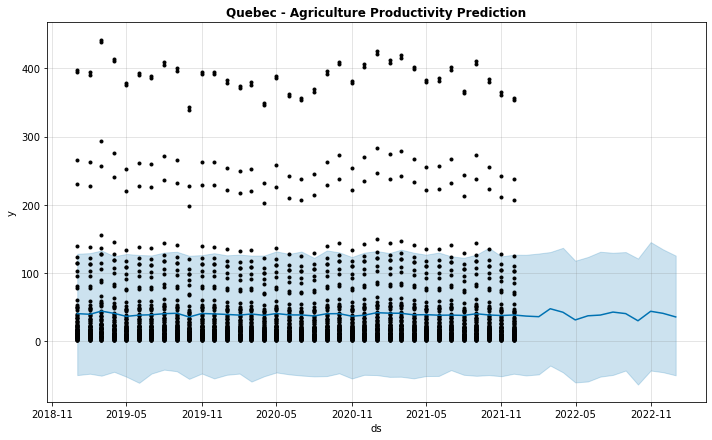

In [130]:
#plot graphs for predictions X axis as time and Y axis as productivity
fig3 = m3.plot(predictions3)
plt.title('Quebec - Agriculture Productivity Prediction', fontweight='bold')
plt.show()

In [131]:
plot_plotly(m3, predictions3)

4.Ontario

In [132]:
# filter for ontario
df4 = df[df['provincename'] == 'Ontario']

In [133]:
# 
df4 = df4.reset_index()
df4[['ds','y']]= df4[['Date/Time','Agriculture']]

#checking changes
df4

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.520607,2.620585,5.959955,8.279386,5.675330,...,5.0,-42.0,0.0,17.6,17.6,27.0,0.0,0.0,2019-01-01,8.279386
1,2019-02-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",9.005601,2.624845,5.973604,7.890537,5.701790,...,-1.5,-37.0,0.0,56.2,56.2,49.0,0.0,0.0,2019-02-01,7.890537
2,2019-03-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.713388,2.621080,5.840579,8.553659,5.841263,...,11.0,-32.0,12.6,17.4,30.0,10.0,0.0,0.0,2019-03-01,8.553659
3,2019-04-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.589379,2.571163,5.965384,8.110945,5.602172,...,20.5,-9.0,9.2,18.8,28.0,0.0,0.0,0.0,2019-04-01,8.110945
4,2019-05-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.755825,2.720747,6.050061,8.527951,5.659821,...,24.5,-6.0,62.2,2.6,64.8,0.0,0.0,0.0,2019-05-01,8.527951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,2021-08-01,Ontario,-74.75,45.02,Akwesasne (Part) 59 (IRI),4.137472,0.000000,4.912784,0.000000,3.282088,...,33.0,11.0,93.8,0.0,93.8,0.0,0.0,0.0,2021-08-01,0.000000
2084,2021-09-01,Ontario,-74.75,45.02,Akwesasne (Part) 59 (IRI),4.191879,0.000000,4.780908,0.000000,3.340783,...,27.5,5.0,75.1,0.0,75.1,0.0,0.0,0.0,2021-09-01,0.000000
2085,2021-10-01,Ontario,-74.75,45.02,Akwesasne (Part) 59 (IRI),4.223592,0.000000,4.797670,0.000000,3.422678,...,24.5,0.0,126.6,0.0,126.6,0.0,0.0,0.0,2021-10-01,0.000000
2086,2021-11-01,Ontario,-74.75,45.02,Akwesasne (Part) 59 (IRI),4.375248,0.000000,4.793911,0.000000,3.438384,...,15.0,-8.5,59.5,5.0,64.5,1.0,0.0,0.0,2021-11-01,0.000000


In [134]:
#to bring in the model the Prophet
model4= df4
model4.head()

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.520607,2.620585,5.959955,8.279386,5.675330,...,5.0,-42.0,0.0,17.6,17.6,27.0,0.0,0.0,2019-01-01,8.279386
1,2019-02-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",9.005601,2.624845,5.973604,7.890537,5.701790,...,-1.5,-37.0,0.0,56.2,56.2,49.0,0.0,0.0,2019-02-01,7.890537
2,2019-03-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.713388,2.621080,5.840579,8.553659,5.841263,...,11.0,-32.0,12.6,17.4,30.0,10.0,0.0,0.0,2019-03-01,8.553659
3,2019-04-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.589379,2.571163,5.965384,8.110945,5.602172,...,20.5,-9.0,9.2,18.8,28.0,0.0,0.0,0.0,2019-04-01,8.110945
4,2019-05-01,Ontario,-93.97,48.63,"Rainy River, Unorganized (NO)",8.755825,2.720747,6.050061,8.527951,5.659821,...,24.5,-6.0,62.2,2.6,64.8,0.0,0.0,0.0,2019-05-01,8.527951


In [135]:
#to drop the unwanted columns in new dataframe
prophet_4 = model4[['ds', 'y']]
prophet_4

,ds,y
0,2019-01-01,8.279386
1,2019-02-01,7.890537
2,2019-03-01,8.553659
3,2019-04-01,8.110945
4,2019-05-01,8.527951
...,...,...
2083,2021-08-01,0.000000
2084,2021-09-01,0.000000
2085,2021-10-01,0.000000
2086,2021-11-01,0.000000


In [136]:
#to fit the model and the dataframe
m4 = Prophet()
m4.fit(prophet_4)

21:11:24 - cmdstanpy - INFO - Chain [1] start processing
21:11:24 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
#predict the future for next 365 periods (1 year). For the 2022 year
future4 = m4.make_future_dataframe(periods=13, freq='M')
future4.tail()

,ds
44,2022-08-31
45,2022-09-30
46,2022-10-31
47,2022-11-30
48,2022-12-31


In [138]:
#calculate predict method to assign each row in future a predicted value which it names yhat
predictions4= m4.predict(future4)
predictions4[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
44,2022-08-31,75.979026,-43.776702,198.697108
45,2022-09-30,76.606943,-38.302962,190.563427
46,2022-10-31,75.283646,-44.531527,190.104250
47,2022-11-30,72.595014,-46.661434,178.579736
48,2022-12-31,76.567991,-41.032595,184.653474


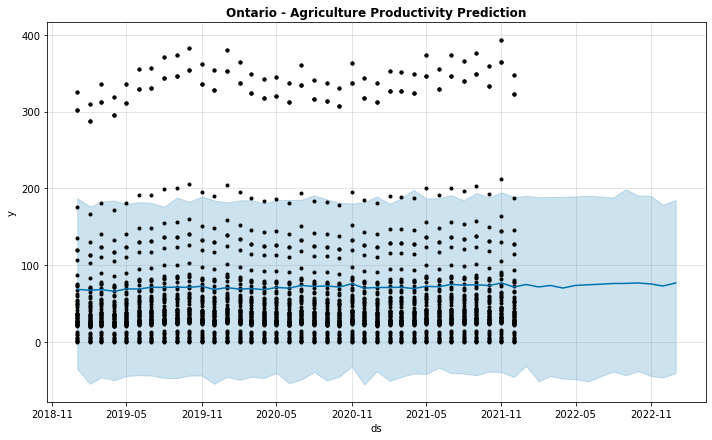

In [139]:
#plot graphs for predictions X axis as time and Y axis as productivity
fig4 = m4.plot(predictions4)
plt.title('Ontario - Agriculture Productivity Prediction', fontweight='bold')
plt.show()

In [140]:
plot_plotly(m4, predictions4)

5.Saskatchewan

In [141]:
# filter for british
df5 = df[df['provincename'] == 'Saskatchewan']

In [142]:
# 
df5 = df5.reset_index()
df5[['ds','y']]= df5[['Date/Time','Agriculture']]

#checking changes
df5

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.808482,0.000000,2.924506,98.740503,2.602189,...,9.3,-22.4,0.0,0.0,30.4,20.0,32.0,66.0,2019-01-01,98.740503
1,2019-02-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.857852,0.000000,3.058354,97.907431,2.661832,...,4.6,-31.4,0.0,0.0,19.7,40.0,33.0,59.0,2019-02-01,97.907431
2,2019-03-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.945189,0.000000,2.978741,93.939489,2.606020,...,12.9,-32.0,0.0,0.0,7.1,1.0,33.0,54.0,2019-03-01,93.939489
3,2019-04-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.852325,0.000000,2.998656,99.420766,2.611399,...,20.2,-9.7,0.0,0.0,76.6,29.0,36.0,59.0,2019-04-01,99.420766
4,2019-05-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.759070,0.000000,2.859852,97.068354,2.587756,...,24.9,-10.6,0.0,0.0,26.7,0.0,29.0,54.0,2019-05-01,97.068354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,2021-08-01,Saskatchewan,-102.12,49.32,Moose Creek No. 33 (RM),0.909181,2.747325,1.323486,55.639642,1.403847,...,39.0,5.5,49.6,0.0,49.6,0.0,0.0,0.0,2021-08-01,55.639642
1796,2021-09-01,Saskatchewan,-102.12,49.32,Moose Creek No. 33 (RM),0.861926,2.711865,1.377199,50.240505,1.291944,...,32.5,-1.5,8.2,0.0,8.2,0.0,0.0,0.0,2021-09-01,50.240505
1797,2021-10-01,Saskatchewan,-102.12,49.32,Moose Creek No. 33 (RM),0.890384,2.997878,1.386481,48.999544,1.326735,...,30.5,-9.5,29.4,0.0,29.4,0.0,0.0,0.0,2021-10-01,48.999544
1798,2021-11-01,Saskatchewan,-102.12,49.32,Moose Creek No. 33 (RM),0.886212,2.954423,1.387618,53.385048,1.372212,...,17.5,-16.0,7.6,9.0,16.6,0.0,0.0,0.0,2021-11-01,53.385048


In [143]:
#to bring in the model the Prophet
model5= df5
model5.head()

,Date/Time,provincename,Longitude,Latitude,Region.Name,Construction,Transportation and warehousing,Health care and social assistance,Agriculture,Wholesale trade Retail trade,...,Extr Max Temp (°C),Extr Min Temp (°C),Total Rain (mm),Total Snow (cm),Total Precip (mm),Snow Grnd Last Day (cm),Dir of Max Gust (10s deg),Spd of Max Gust (km/h),ds,y
0,2019-01-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.808482,0.0,2.924506,98.740503,2.602189,...,9.3,-22.4,0.0,0.0,30.4,20.0,32.0,66.0,2019-01-01,98.740503
1,2019-02-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.857852,0.0,3.058354,97.907431,2.661832,...,4.6,-31.4,0.0,0.0,19.7,40.0,33.0,59.0,2019-02-01,97.907431
2,2019-03-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.945189,0.0,2.978741,93.939489,2.606020,...,12.9,-32.0,0.0,0.0,7.1,1.0,33.0,54.0,2019-03-01,93.939489
3,2019-04-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.852325,0.0,2.998656,99.420766,2.611399,...,20.2,-9.7,0.0,0.0,76.6,29.0,36.0,59.0,2019-04-01,99.420766
4,2019-05-01,Saskatchewan,-109.51,49.64,Maple Creek No. 111 (RM),3.759070,0.0,2.859852,97.068354,2.587756,...,24.9,-10.6,0.0,0.0,26.7,0.0,29.0,54.0,2019-05-01,97.068354


In [144]:
#to drop the unwanted columns in new dataframe
prophet_5 = model5[['ds', 'y']]
prophet_5

,ds,y
0,2019-01-01,98.740503
1,2019-02-01,97.907431
2,2019-03-01,93.939489
3,2019-04-01,99.420766
4,2019-05-01,97.068354
...,...,...
1795,2021-08-01,55.639642
1796,2021-09-01,50.240505
1797,2021-10-01,48.999544
1798,2021-11-01,53.385048


In [145]:
#to fit the model and the dataframe
m5 = Prophet()
m5.fit(prophet_5)

21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing


In [146]:
#predict the future for next 365 periods (1 year). For the 2022 year
future5 = m5.make_future_dataframe(periods=13, freq='M')
future5.tail()

,ds
44,2022-08-31
45,2022-09-30
46,2022-10-31
47,2022-11-30
48,2022-12-31


In [147]:
#calculate predict method to assign each row in future a predicted value which it names yhat
predictions5= m5.predict(future5)
predictions5[['ds','yhat','yhat_lower','yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
44,2022-08-31,40.575821,1.647652,78.706199
45,2022-09-30,50.478141,12.420510,90.249359
46,2022-10-31,43.823541,6.814366,79.211634
47,2022-11-30,44.361274,6.629481,81.891922
48,2022-12-31,42.266415,5.250785,79.292511


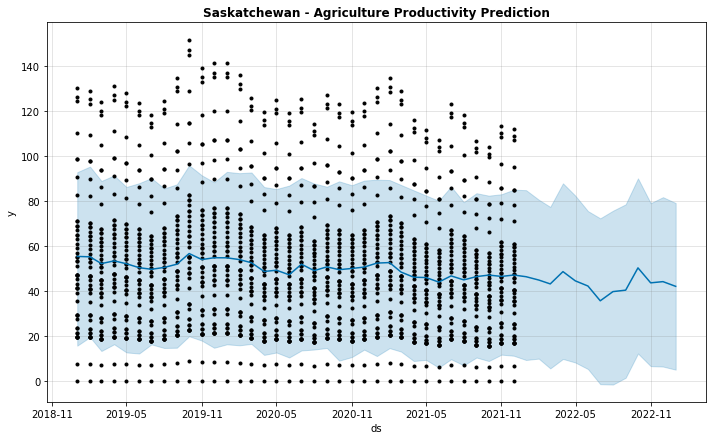

In [148]:
#plot graphs for predictions X axis as time and Y axis as productivity
fig5 = m5.plot(predictions5)
plt.title('Saskatchewan - Agriculture Productivity Prediction', fontweight='bold')
plt.show()

In [149]:
plot_plotly(m5, predictions5)